## **Predictive classification of female children's nutritional status based on their age and height**


## Introduction

WHO defines stunted growth as “the impaired growth and development that children experience from poor nutrition, repeated infection, and inadequate psychosocial stimulation” (*Stunting in a Nutshell*, 2015). The "Stunting Baby/Toddler Detection" dataset, collected from Kaggle, compiles data of toddlers ages 0 to 60 months and determines their nutritional status–severely stunted, stunted, normal, and tall–based on WHO’s z-score formula. This dataset will be used to analyze 2440 cases to predict a female child's nutritional status based on age and height and to design a reliable prediction model.

The research question of the project is: 
	Can we predict the nutritional status of a female child based on age and height?


## Methods: 
**1. Cleaning up the data**
* Translate all non-English values in the raw data set into English.
* Filter out the data set by the sex variable so only female observations are left.
  
**2. Separating the training data set and test data set**
* Set a specific seed for the random split of our data set into the training data set and test data set, so the data analysis process can be reproduced.
* Using initial_split, randomly divide the data set into a training set and a testing set by 70% to 30% ratio.
  
**3. Preprocessing (scaling) the training data set**
* Create a recipe for scaling and centering of the training data set using recipe, step_scale, and step_center
* Create a model specification for classification.

**4. Training the classifier**
* Add the recipe and model specification to the workflow, then estimate the classification accuracy for a range of K values.
* Determine the appropriate number of K for the nearest neighbor method for this data set.
* Set the engine and mode for specification
* Create a workflow for fitting by adding the recipe and the model

**5. Presenting the data**
* Create a confusion matrix table that shows true and false cases of prediction for stunted cases and healthy nutritional status
* Reflect on our model such as the number of K, using the cross-validation method.

**6. Analysis and evaluation of our prediction**
* Compared to the actual nutritional status of test data set observations, evaluate the precision, recall, and accuracy of our prediction model based on the confusion matrix created.
* Think about the real-life implications of the data and the conclusion that can be drawn from its analysis, then reflect and determine what kind of predictive model would suit best.

## Preliminary exploratory data analysis:

In [1]:
library(tidyverse)
library(dplyr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

**Importing the dataset**

We download the file from the URL and then load it into the workspace using the `read_csv` method.

In [2]:
url = "https://raw.githubusercontent.com/nmahaj03/DSCI-100_Grp30_Project/main/GrowthStatus%20Dataset.csv"
download.file(url, "GrowthStatus Dataset.csv")
growth_data = read_csv("GrowthStatus Dataset.csv") 
colnames(growth_data) <- c('Age_Months','Sex','Height_cm', 'Nutritional_Status')
write_csv(growth_data,"GrowthStatus Dataset.csv")

Rows: 120999 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Sex, Nutritional_Status
dbl (2): Age_Months, Height_cm

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## 

**We Subset the data pertaining to females and Store it in GrowthStatusFemale Dataset.csv.**

In [3]:
set.seed(1234)
growth_data_female = growth_data |>
                        filter(Sex == "Female") |>
                        mutate(Nutritional_Status = as_factor(Nutritional_Status))

growth_data_female = growth_data_female |>
                            sample_frac(0.04, replace = FALSE)

growth_data_female

write_csv(growth_data_female,"GrowthStatusFemale Dataset.csv")

Age_Months Sex    Height_cm Nutritional_Status
1    40         Female 105.7     normal            
2    40         Female 111.6     Tall              
3    41         Female 113.9     Tall              
⋮    ⋮          ⋮      ⋮         ⋮                 
2438 35         Female 92.6      normal            
2439  9         Female 80.4      Tall              
2440 48         Female 96.1      normal

##

**The dataset is split into Training and Testing dataframes.**

In [4]:
set.seed(3456) 
growth_data_fem_split <- initial_split(growth_data_female, prop = 0.70, strata = Nutritional_Status)  

growth_data_fem_split

<Training/Testing/Total>
<1706/734/2440>

In [5]:
growth_data_fem_train <- training(growth_data_fem_split)
growth_data_fem_test <- testing(growth_data_fem_split)

##
 
 **First few rows of the training dataset presented using the glimpse function.**

In [6]:
#Structure of the training dataset obtained using the glimpse function.
glimpse(growth_data_fem_train)

Rows: 1,706
Columns: 4
$ Age_Months         <dbl> 40, 17, 19, 59, 32, 31, 50, 33, 55, 2, 46, 33, 51, …
$ Sex                <chr> "Female", "Female", "Female", "Female", "Female", "…
$ Height_cm          <dbl> 105.70000, 76.40000, 86.20000, 109.10000, 88.90000,…
$ Nutritional_Status <fct> normal, normal, normal, normal, normal, normal, nor…


This way we can make sure that there are no noticeable abnormalities in the training dataset at first glance.

**The Summary Function provides the Statistical Summary of the Dataset.**

In [7]:
#The Summary Function provides the Statistical Summary of the Dataset.
summary(growth_data_fem_train)

   Age_Months     Sex              Height_cm             Nutritional_Status
 Min.   : 0   Length:1706        Min.   : 40.52   severely stunted:255     
 1st Qu.:15   Class :character   1st Qu.: 75.80   Tall            :283     
 Median :30   Mode  :character   Median : 88.65   stunted         :224     
 Mean   :30                      Mean   : 88.08   normal          :944     
 3rd Qu.:45                      3rd Qu.:100.80                            
 Max.   :60                      Max.   :127.10                            

**Obtaining the means of Predictors grouped by Nutritional Status.**

In [26]:
growth_data_fem_train_mean = growth_data_fem_train |>
                            group_by(Nutritional_Status) |>
                            summarize(mean_Age = mean(Age_Months),
                                      mean_Height = mean(Height_cm))

growth_data_fem_train_mean

[1] "Table 1"


Nutritional_Status mean_Age mean_Height
1 severely stunted   25.24314 71.81832   
2 Tall               23.96466 94.69261   
3 stunted            33.70089 82.41936   
4 normal             32.21610 91.83126

***Table 1***

This table gives us the mean age and mean_height. Both these statistics are not related. We can see that there is a greater number of kids with a nutritional status of either severely stunted or tall, among infants than in toddlers. 

**Obtaining Distributions of the class to be predicted.**

In [9]:
#Obtaining Distributions of the class to be predicted.
nutrition_proportions <- growth_data_fem_train |>
                      group_by(Nutritional_Status) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(growth_data_fem_train))


nutrition_proportions

Nutritional_Status n   percent 
1 severely stunted   255 14.94725
2 Tall               283 16.58851
3 stunted            224 13.13013
4 normal             944 55.33411

***Table2***

This gives us an insight into the distribution of data we are working with. It is concurrent with our expectations that a vast majority of the observations have a normal nutritional status.

**Standardizing the data and preprocessing by scaling it.**


In [10]:
#Standardizing the data.
growth_recipe <- recipe(Nutritional_Status ~ Height_cm + Age_Months, data = growth_data_fem_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |> 
  prep()

In [11]:
#Preprocessing the data by scaling it.

scaled_growth_data_fem_train <- bake(growth_recipe, growth_data_fem_train)
scaled_growth_data_fem_train

Height_cm   Age_Months Nutritional_Status
1     1.0164760   0.5701602 normal            
2    -0.6736839  -0.7412083 normal            
3    -0.1083744  -0.6271762 normal            
⋮    ⋮           ⋮          ⋮                 
1704  1.62793317  0.8552403 Tall              
1705 -0.07376364 -0.9692723 Tall              
1706 -0.44294532 -1.1973364 Tall

**Scatterplot of the unscaled training data.**

We use the unscaled training data to create a plot to view the distribution of the data points with respect to the predictors.

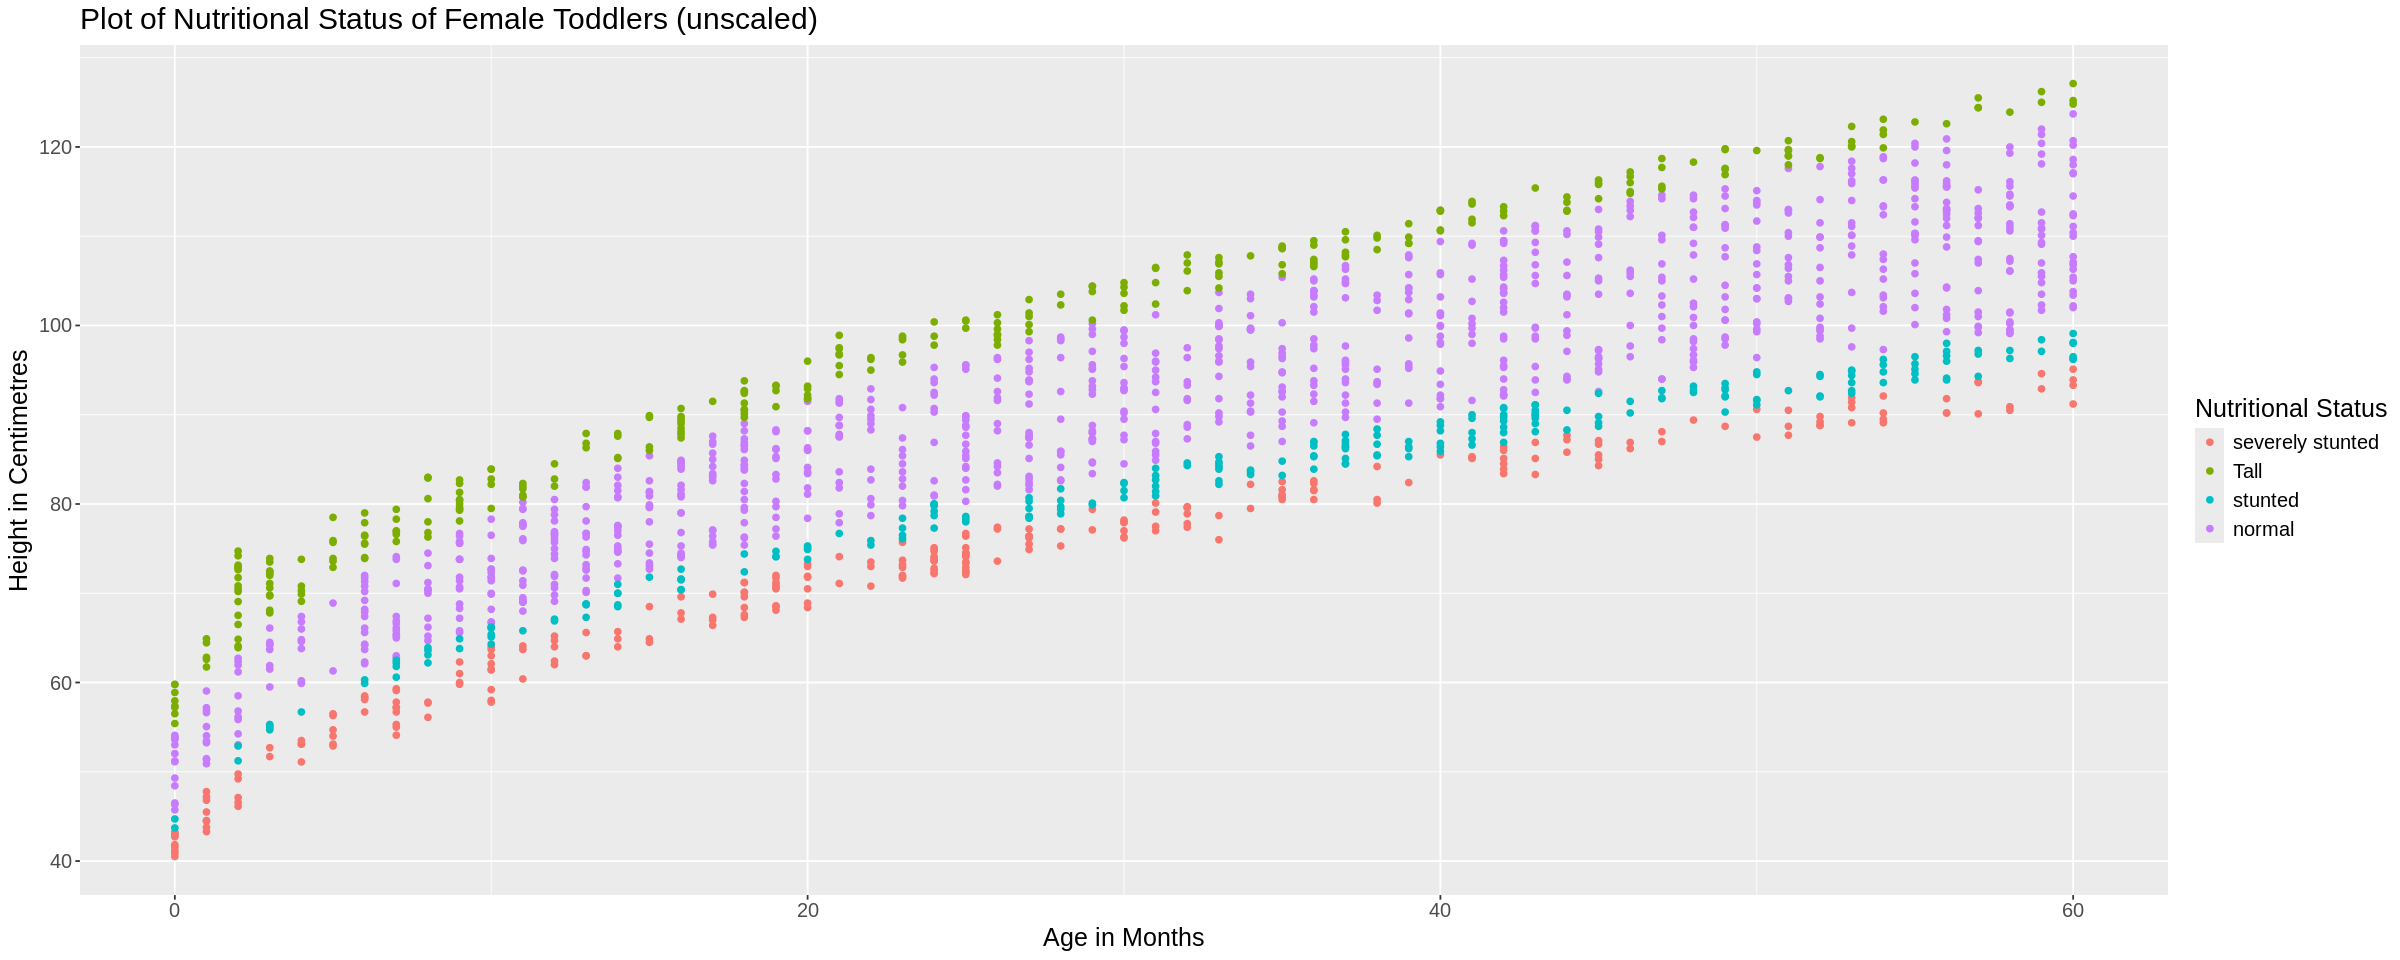

In [30]:

options(repr.plot.width = 20, repr.plot.height = 8)
unscaled_fem_growth_plot <- growth_data_fem_train|>
                            ggplot(aes(x = Age_Months, y= Height_cm, color= Nutritional_Status))+
                            geom_point() +
                            labs(x= "Age in Months", y= "Height in Centimetres",color = "Nutritional Status")+
                            ggtitle("Plot of Nutritional Status of Female Toddlers (unscaled)") +
                            theme(text = element_text(size = 15))

unscaled_fem_growth_plot

***Plot 1***




##

**Scatterplot of the scaled training data.**

We use the scaled data to create a more appropriate visualization where we can estimate the distance between points with lesser efforts.

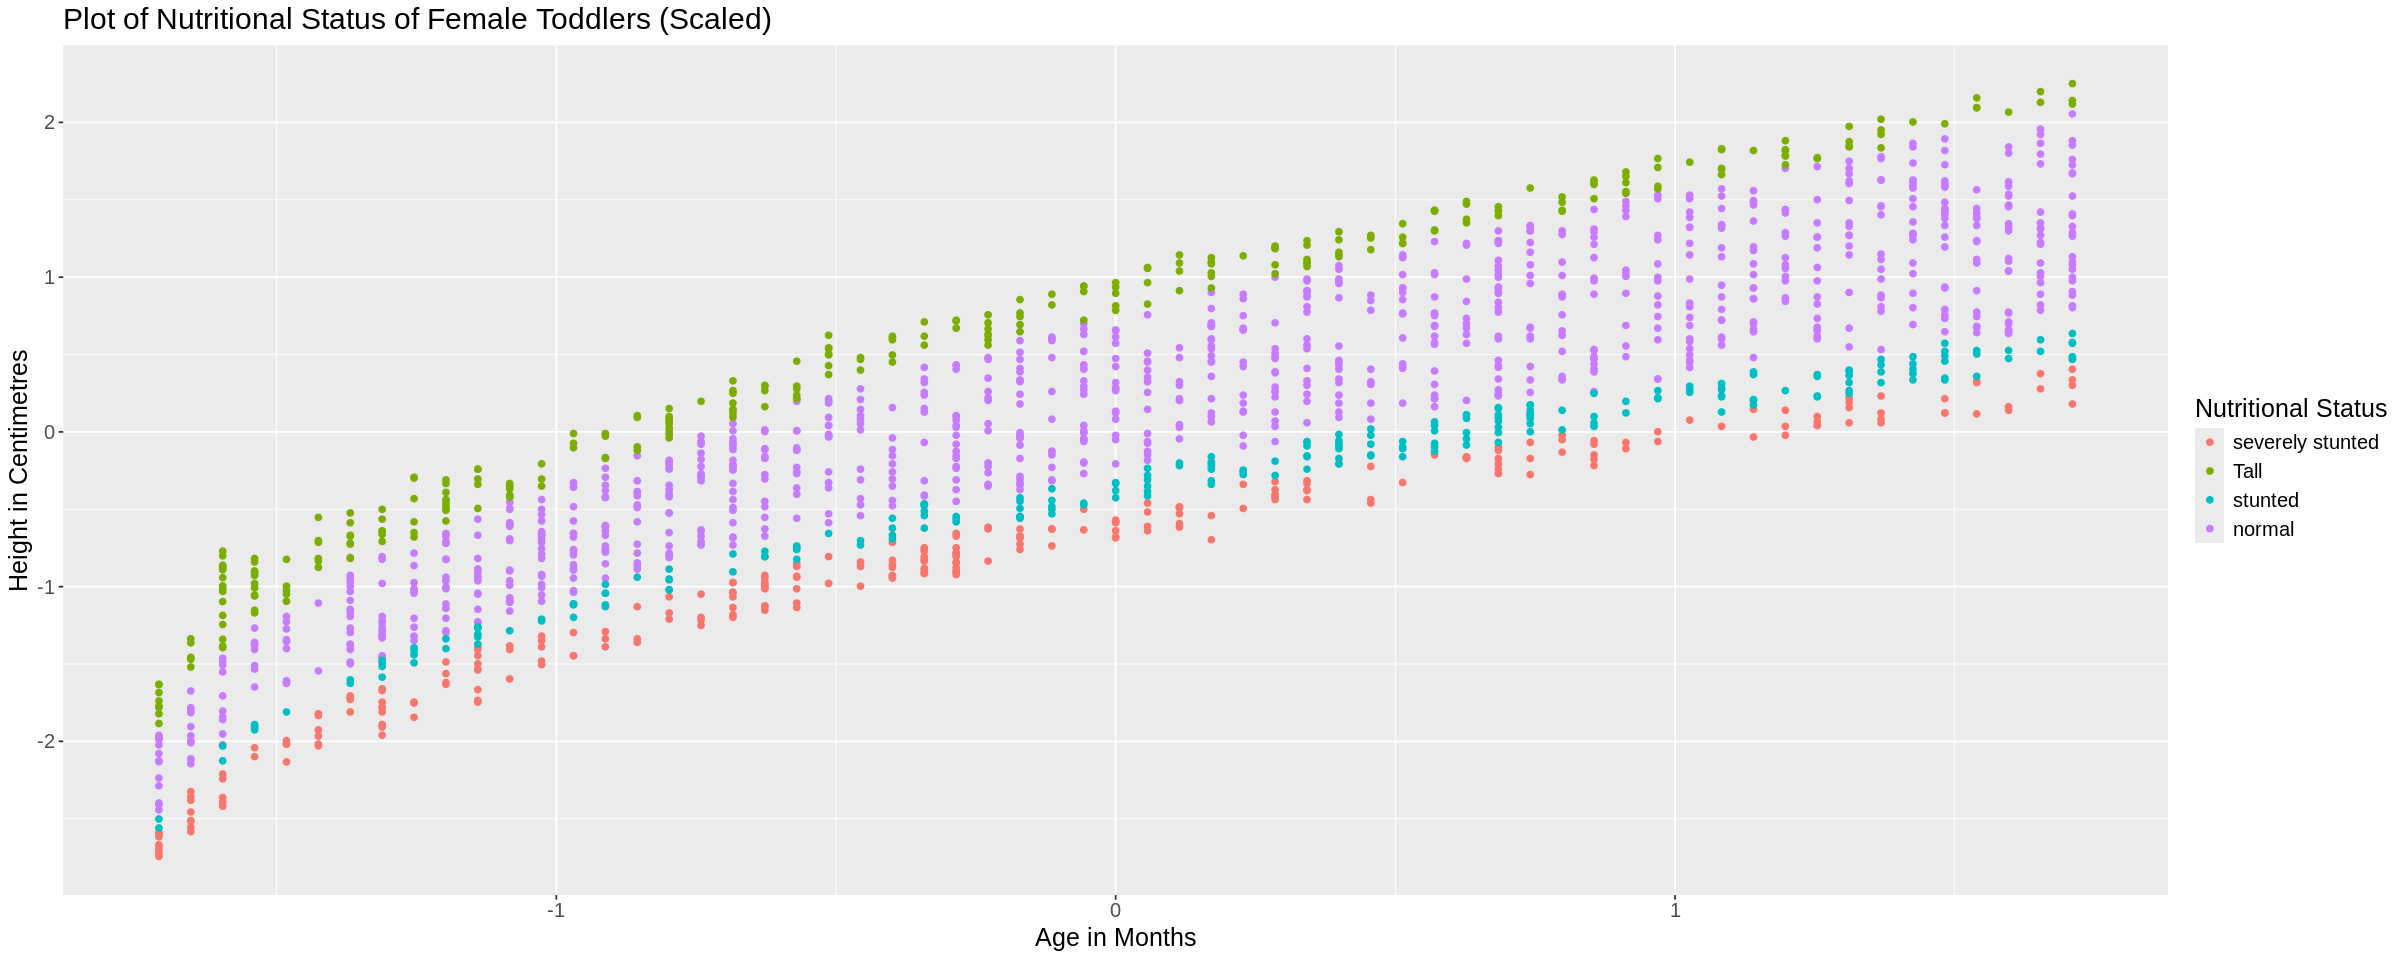

In [31]:

options(repr.plot.width = 20, repr.plot.height = 8)
scaled_fem_growth_plot <- scaled_growth_data_fem_train|>
                            ggplot(aes(x = Age_Months, y= Height_cm, color= Nutritional_Status))+
                            geom_point() +
                            labs(x= "Age in Months", y= "Height in Centimetres",color = "Nutritional Status")+
                            ggtitle("Plot of Nutritional Status of Female Toddlers (Scaled)") + 
                            theme(text = element_text(size = 15))

scaled_fem_growth_plot

***Plot 2***

##

**Histogram of the data distribution by Age.**

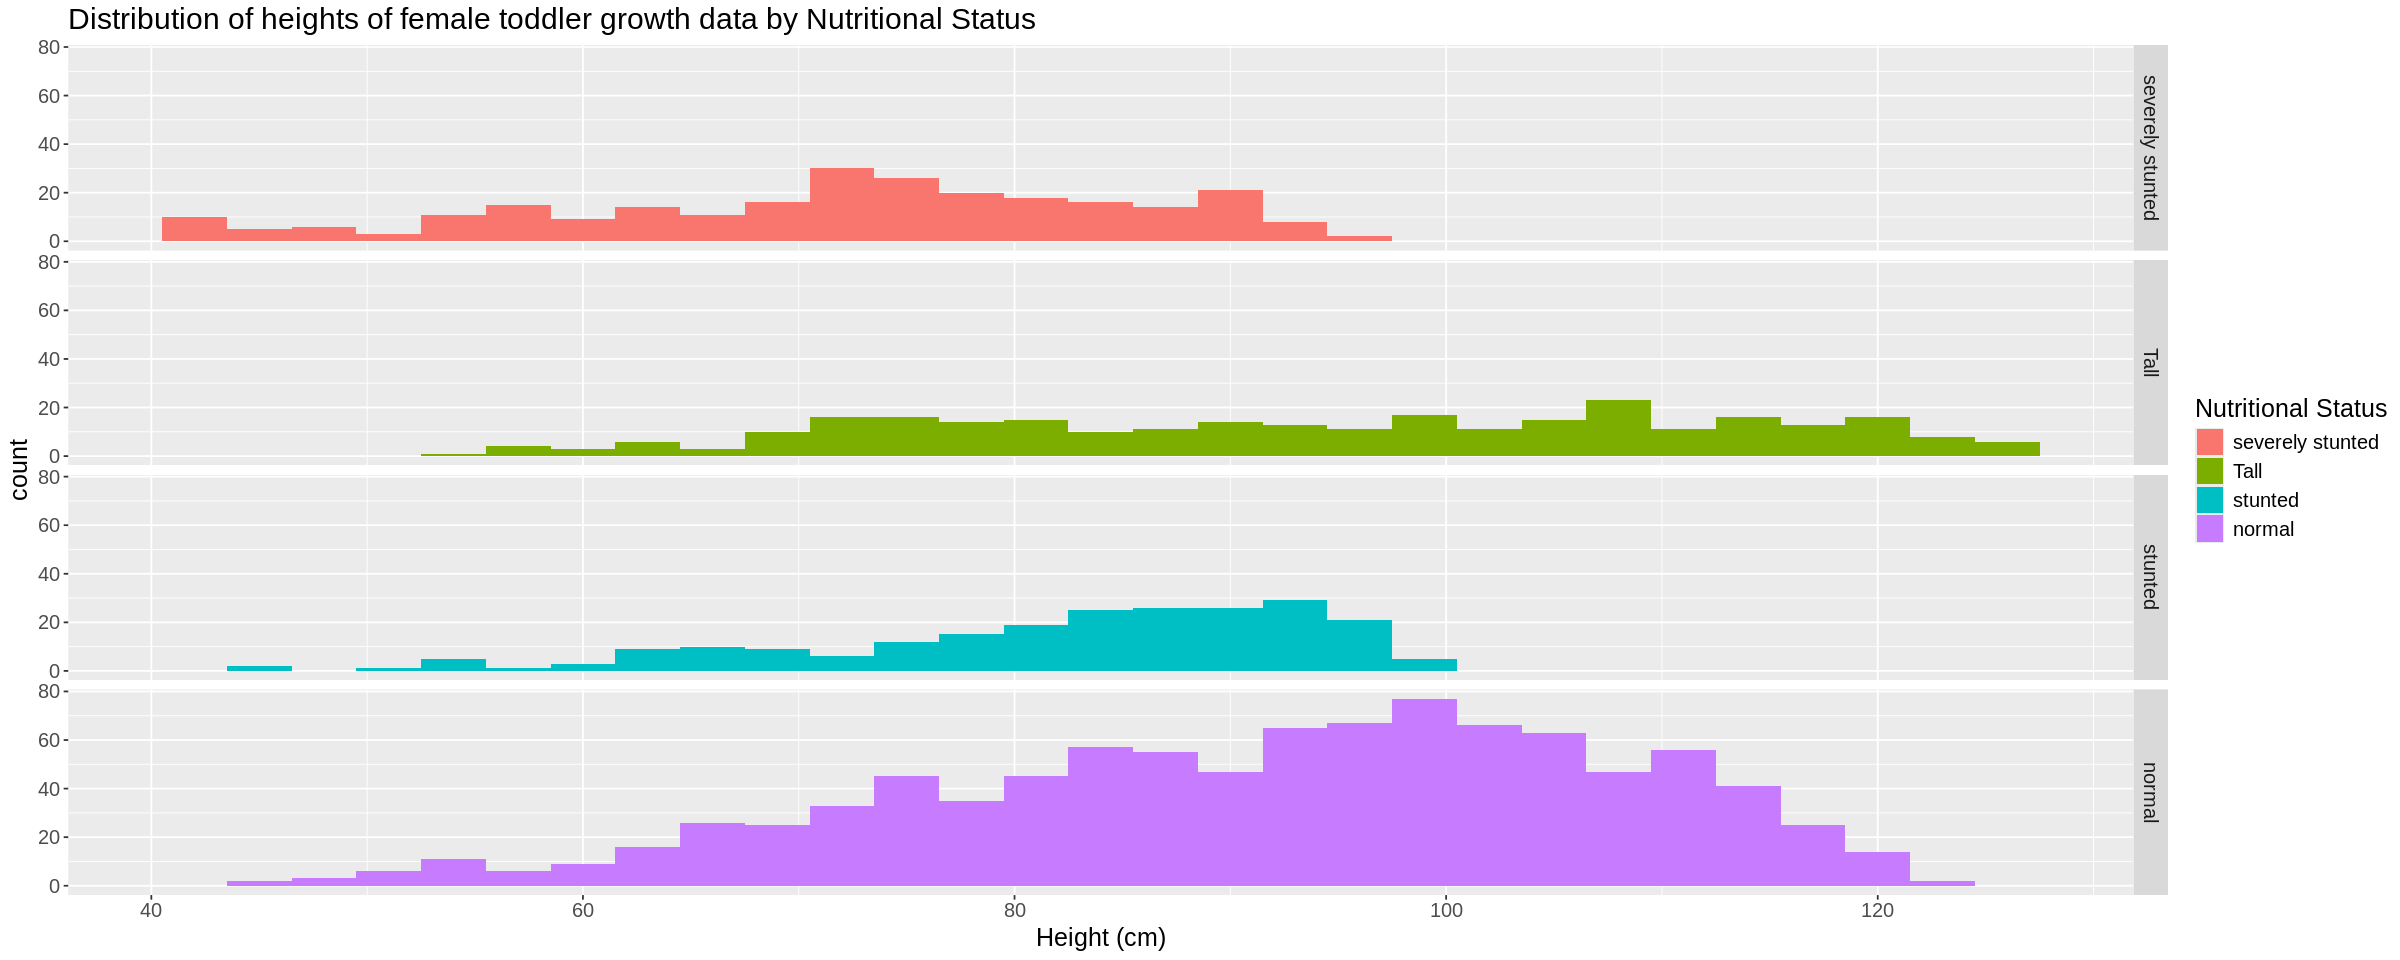

In [14]:
#Histogram of the data distribution.

female_growth_data_hist <- ggplot(growth_data_fem_train, aes(x = Height_cm, fill = as_factor(Nutritional_Status))) +
  geom_histogram(binwidth = 3) +
  facet_grid(rows = vars(Nutritional_Status))+
labs(x = "Height (cm)", fill = "Nutritional Status") +
ggtitle("Distribution of heights of female toddler growth data by Nutritional Status") + 
theme(text = element_text(size = 15))

female_growth_data_hist

***Plot 3***

##

**Bar Plot depicting the distribution by age and nutrition status.**

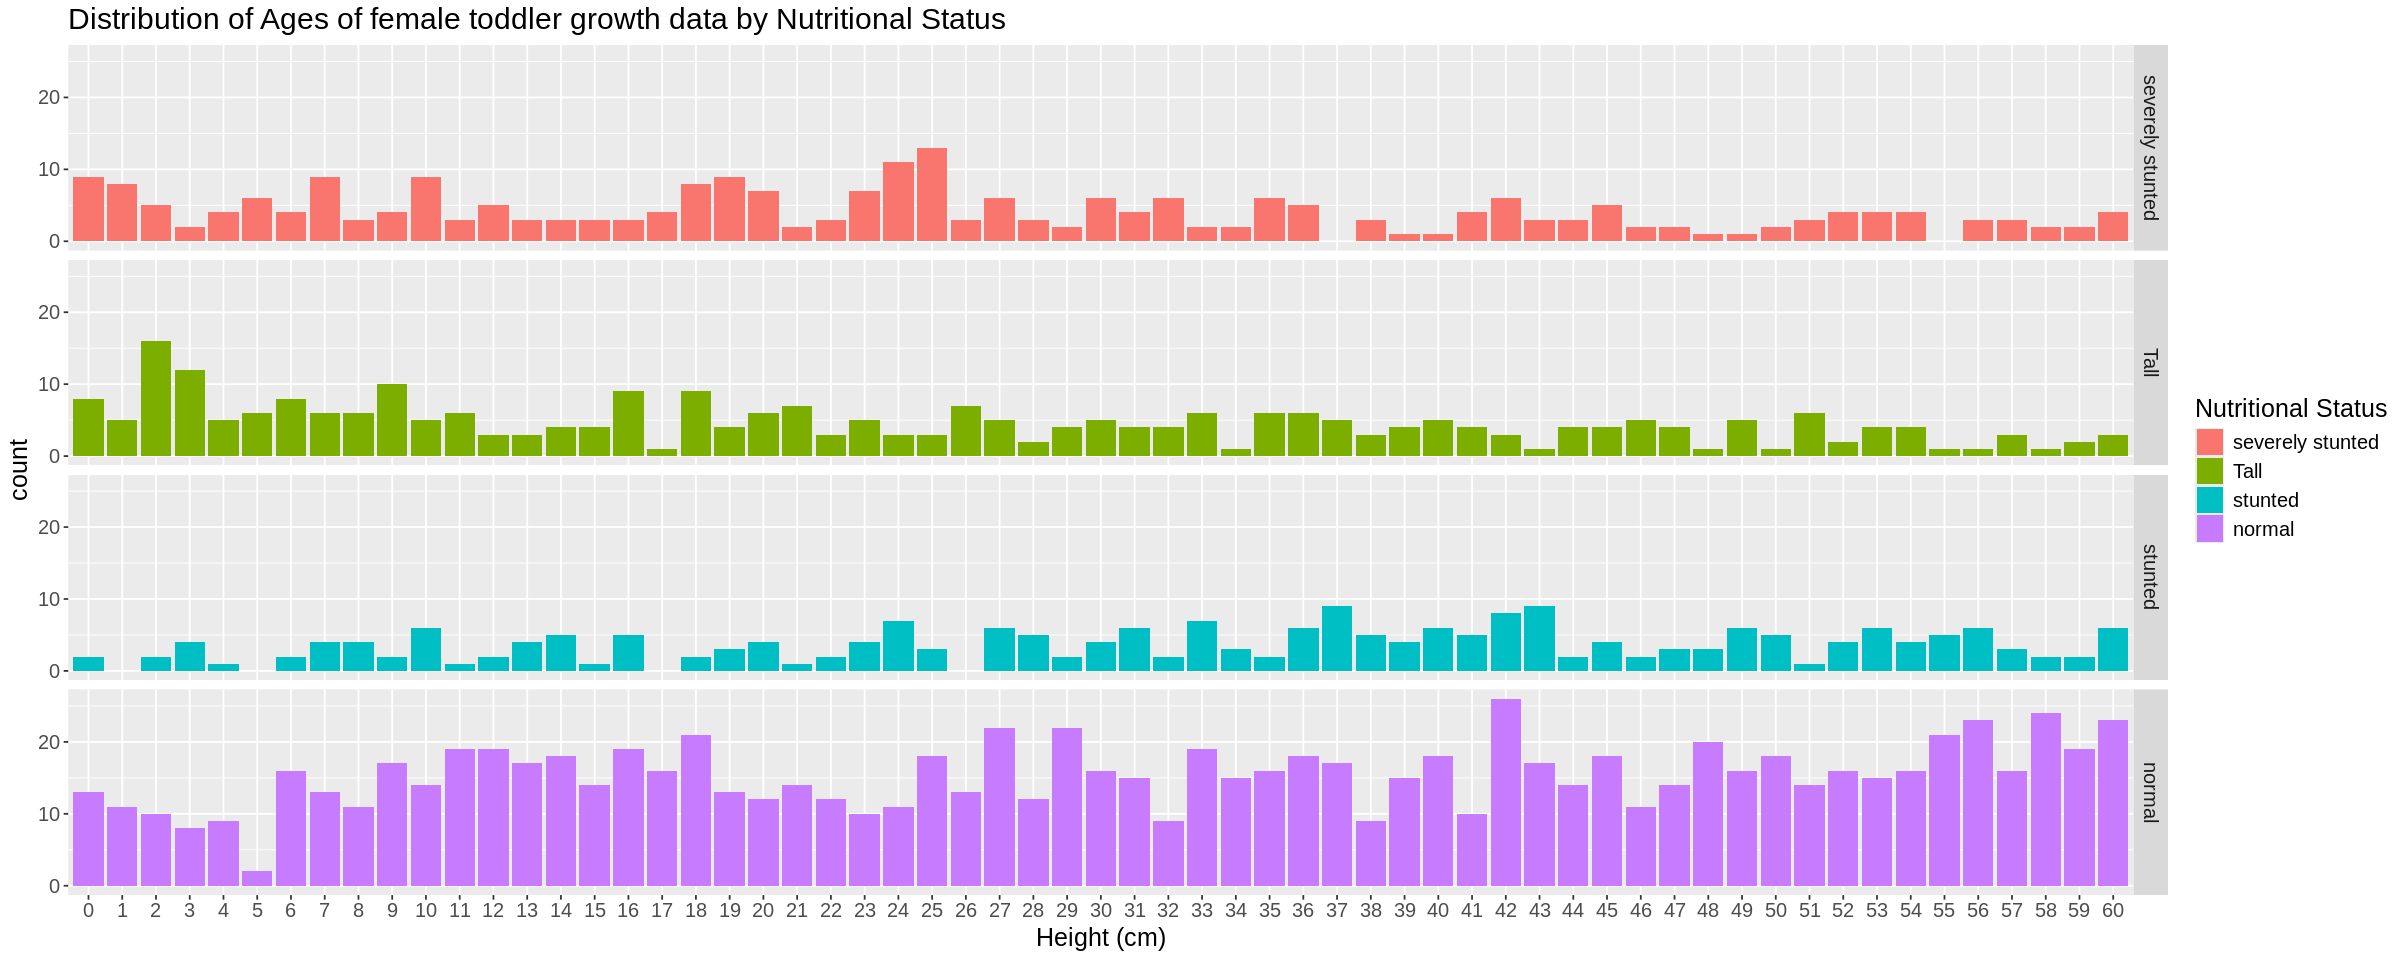

In [15]:
#Bar Plot depicting the distribution by age and nutrition status.
female_growth_data_bar <- ggplot(growth_data_fem_train, aes(x = as_factor(Age_Months), fill = as_factor(Nutritional_Status))) +
  geom_bar() +
  facet_grid(rows = vars(Nutritional_Status))+
labs(x = "Height (cm)", fill = "Nutritional Status") +
ggtitle("Distribution of Ages of female toddler growth data by Nutritional Status") + 
theme(text = element_text(size = 15))


female_growth_data_bar

***Plot 4***

**Performing Cross Validation**

We use the `vfold_cv` function to obtain an analysis of the classifier's performance at varied K values

In [16]:

female_growth_vfold = vfold_cv(growth_data_fem_train, v = 7, strata = Nutritional_Status)
female_growth_vfold

splits                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

##

**Tuning the knn_spec and obtaining performance metrics for the classifier for different K values.**

We create a workflow with a tuned knn specification. We use our results from the cross validation to obtain performace metrics of the classification (in this case, accuracy).

In [17]:

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

#This creates a sequence of neighbor values for k from 1 to 50.
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() |>
  add_recipe(growth_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = female_growth_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")


accuracies

neighbors .metric  .estimator mean      n std_err     .config              
1  1         accuracy multiclass 0.9531004 7 0.003455982 Preprocessor1_Model01
2  2         accuracy multiclass 0.9536883 7 0.003435524 Preprocessor1_Model02
3  3         accuracy multiclass 0.9507560 7 0.004027232 Preprocessor1_Model03
⋮  ⋮         ⋮        ⋮          ⋮         ⋮ ⋮           ⋮                    
48 48        accuracy multiclass 0.8639540 7 0.008707109 Preprocessor1_Model48
49 49        accuracy multiclass 0.8557596 7 0.006927909 Preprocessor1_Model49
50 50        accuracy multiclass 0.8540031 7 0.007116159 Preprocessor1_Model50

##

**We create a  plot for K vs accuracy of the classifier to visually analyze the relation and get a rough estimate of what the K value could be.**


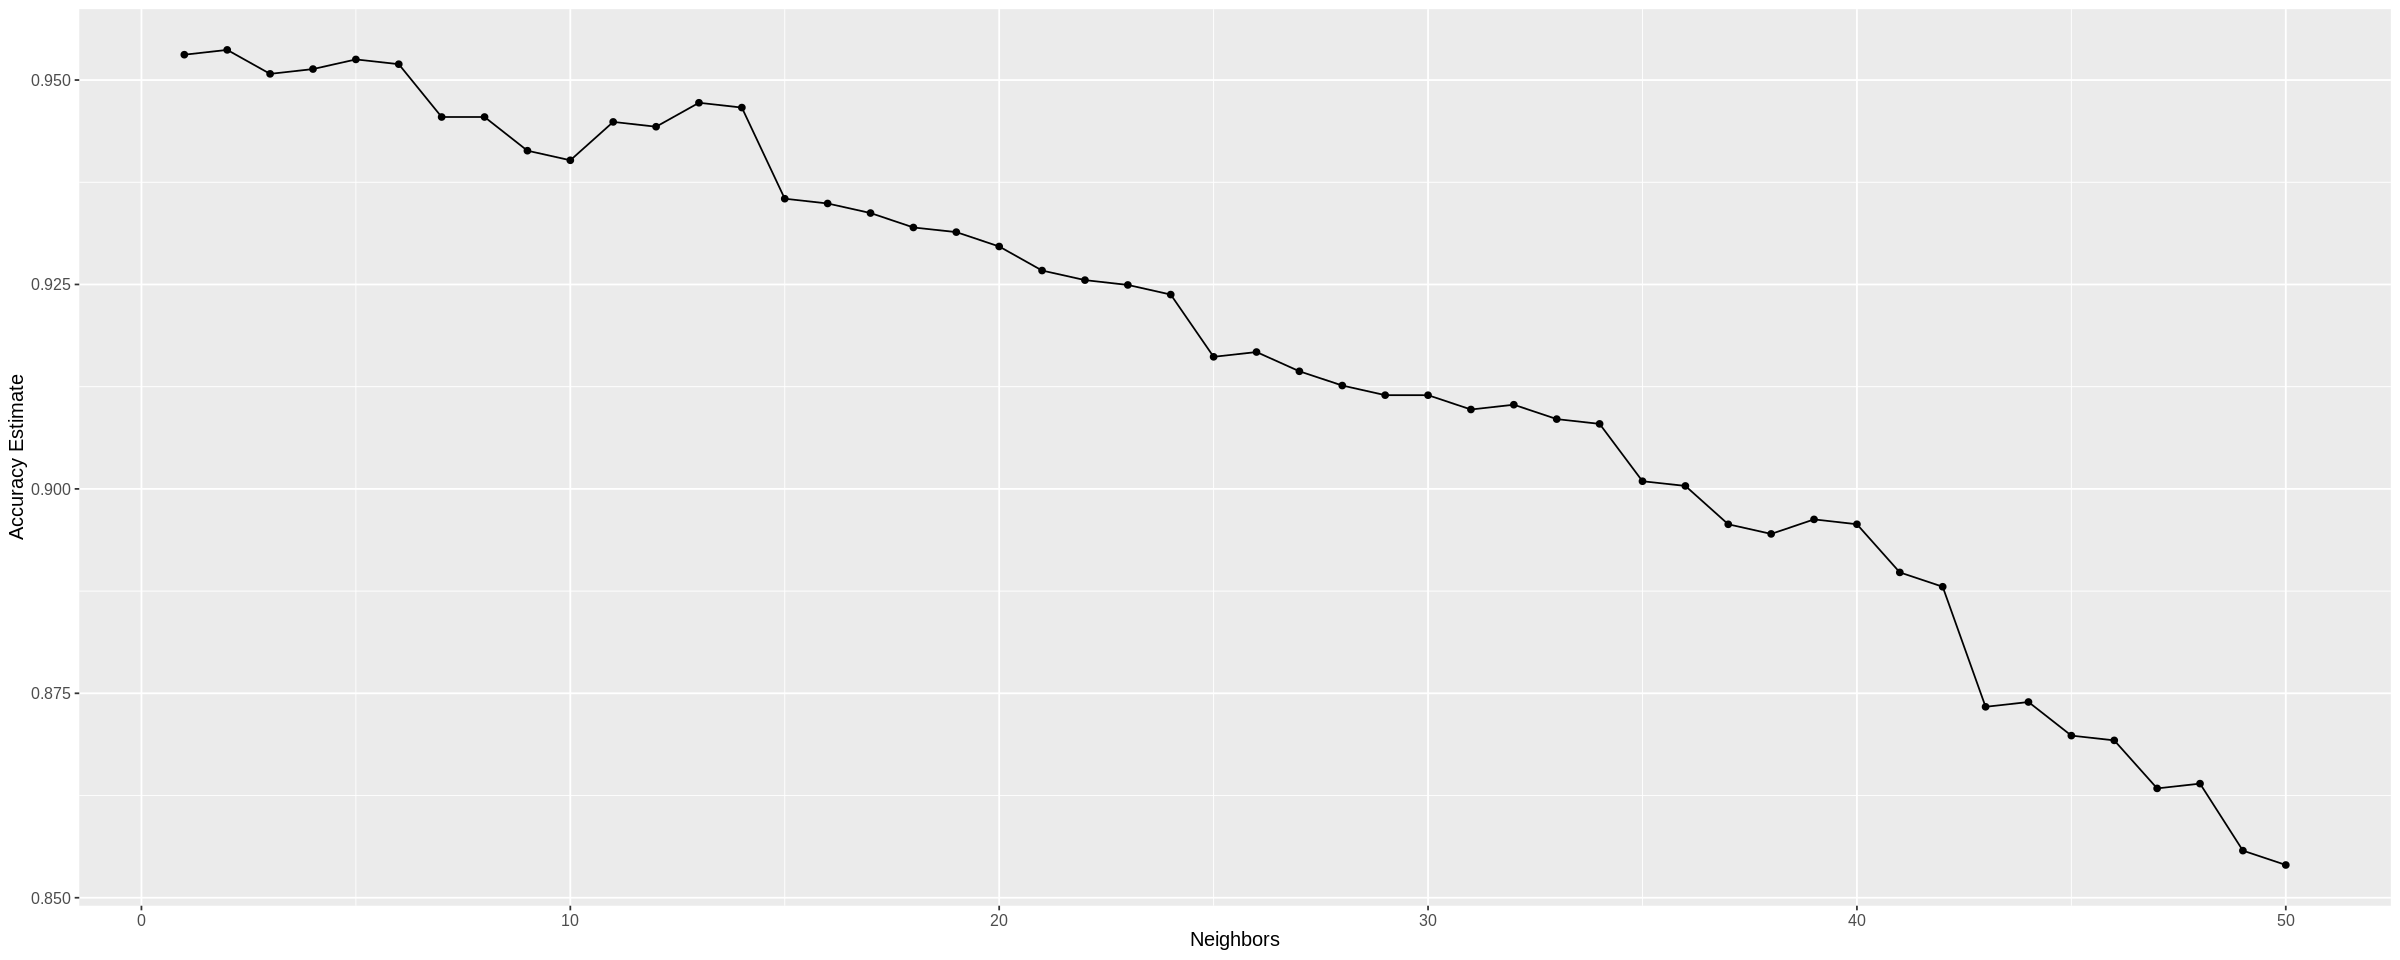

In [18]:

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

***Plot 5***

We can see that the accuracy of the model decreases as k increases. k=2 has the highest accuracy, but may not be the best option considering a higher margin of overfitting.


##

**We obtain the best possible candidates that can be used as K in our classifier.**

In [19]:
best_ks <- accuracies |>
        arrange(desc(mean)) |>
        head(12) |>
        pull(mean,neighbors)
best_ks

2         1         5         6         4         3        13        14 
0.9536883 0.9531004 0.9525222 0.9519391 0.9513439 0.9507560 0.9472215 0.9466336 
        7         8        11        12 
0.9454795 0.9454795 0.9448796 0.9442917

##

**Training the classifier with the chosen K value**

We pick K = 13 for three reasons:

- It is an odd number, hence ties are eliminated.
- Choosing a higher k value reduces overfitting.
- The difference in accuracy from the best k is less than 0.008.

In [32]:

growth_recipe <- recipe(Nutritional_Status ~ Height_cm + Age_Months, data = growth_data_fem_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(growth_recipe) |>
  add_model(knn_spec) |>
  fit(data = growth_data_fem_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.05392732
Best kernel: rectangular
Best k: 13

##


**We obtain the best possible candidates that can be used as K in our classifier.**

In [33]:

fem_growth_test_predictions <- predict(knn_fit, growth_data_fem_test) |>
  bind_cols(growth_data_fem_test)

fem_growth_test_predictions |>
  metrics(truth = Nutritional_Status, estimate = .pred_class) |>
  filter(.metric == "accuracy")

fem_growth_test_predictions |>
    precision(truth = Nutritional_Status, estimate = .pred_class, event_level="first")


fem_growth_test_predictions |>
    recall(truth = Nutritional_Status, estimate = .pred_class, event_level="first")

.metric  .estimator .estimate
1 accuracy multiclass 0.9373297

.metric   .estimator .estimate
1 precision macro      0.9277398

.metric .estimator .estimate
1 recall  macro      0.916918

All three metrics suggest a great fit of our model with the classifier identifies positive instances 91.7% of time and predicts the nutritional status with 93.7% accuracy.

##

**We can assess the accuracy of the classifier while predicting each of the classes.**

The confusion matrix is useful tool in helping us understand how well the prediction model works while making predictions related to a particular class.

In [34]:
pred_cm <- fem_growth_test_predictions |>
             conf_mat(truth = Nutritional_Status, estimate = .pred_class)
pred_cm

                  Truth
Prediction         severely stunted Tall stunted normal
  severely stunted              105    0       6      3
  Tall                            0  109       0      7
  stunted                         5    0      82      4
  normal                          0   13       8    392

## Discussion:

Our analysis focused on predicting the nutritional status of female children based on their age and height, analyzing a dataset of 2440 cases. We categorized the nutritional statuses as severely stunted, stunted, normal, and tall. Our data analysis revealed that the mean height for 'severely stunted' children was significantly lower at 71.82 cm compared to 94.69 cm for 'tall' children, showcasing a clear correlation between height, age, and nutritional status​​. Furthermore, the nutritional status proportions showed a higher prevalence of 'normal' status (55.33%) in our sample​​, indicating a baseline for comparing intervention impacts.

The findings align closely with our expectations based on the prior research in pediatric nutrition and exploratory data analysis, which suggest that height and age are critical indicators of nutritional status. The distribution of height across different nutritional statuses with clear boundaries between categories (as seen in the dataset's summary statistics) was expected and validates the utility of height and age as reliable predictors.

The ability to predict nutritional status using age and height can significantly impact public health strategies. For instance, recognizing that 14.95% of children in our dataset were severely stunted​​, targeted nutritional programs and health interventions can be prioritized for this at-risk group. By addressing these children early, programs might reduce the incidence of complications associated with stunted growth, such as reduced cognitive development and higher susceptibility to illnesses.

Since our analysis was confined to a limited number of factors such as age and height, it would be beneficial to explore how other socio-economic, genetic, ethnic, and environmental factors intersect with age and height to influence nutritional status. Incorporating variables such as dietary intake, parental height, and socio-economic status could enhance the predictive power of our models.

With 55.33% of the sample classified as normal, understanding which interventions effectively transition children from 'stunted' or 'severely stunted' to 'normal' could be crucial. Questions such as “Which type of interventions are most effective at improving nutritional status among children identified as at risk?” could be a good place to begin coming up with better intervention methods. Also, Testing various types of interventions focussing on different factors could provide valuable data on effective strategies for combating malnutrition and stunted growth.

From our findings, we can tackle questions such as: What are the long-term outcomes for children identified in different nutritional status categories? A longitudinal study following up on these children could provide insights into the long-term effects of early nutritional status on health and development.

## References:

World Health Organization. (2015, November 19). Stunting in a Nutshell. World Health Organization. https://www.who.int/news/item/19-11-2015-stunting-in-a-nutshell#:~:text=Stunting%20is%20the%20impaired%20growth,WHO%20Child%20Growth%20Standards%20median 

Rendi Putra Pradana. (2024). Stunting Toddler (Balita) Detection (121K rows). Kaggle.com. https://www.kaggle.com/datasets/rendiputra/stunting-balita-detection-121k-rows/data